<a href="https://colab.research.google.com/github/Idan-Alter/OU-22961-Deep-Learning/blob/main/22961_3_2_1_normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

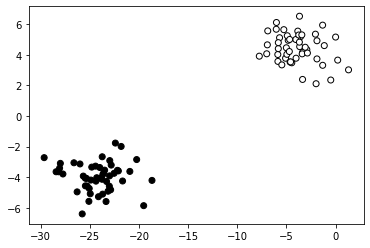

In [ ]:
import sklearn.datasets as skds
import torch
from matplotlib import pyplot as plt
X, Y = skds.make_blobs(n_samples=100, n_features=2,
                       centers=2, random_state=1)
X, Y = torch.tensor(X, dtype=torch.float), torch.tensor(Y, dtype=torch.float)

X[:,0] = 2.5 * X[:,0] #this is new
plt.scatter(X[:, 0], X[:, 1],
            c=Y, cmap="Greys", edgecolor="black");

z         = lambda w0,w1,b,x0,x1: w0*x0 +w1*x1 + b
y         = lambda z: 1/(1 + torch.exp(-z))
eps       = torch.tensor(10**-6)
clip_prob = lambda y: torch.max(eps, torch.min(1-eps,y)) 
model     = lambda w0,w1,b,x0,x1: clip_prob(y(z(w0, w1, b, x0, x1)))
H         = lambda y,yt: -(yt*torch.log(y) + (1-yt)*torch.log(1-y))
C         = lambda cost_per_point: cost_per_point.mean()
cost_by_w0w1 = lambda w0,w1: C(H(model(w0, w1, b, X[:, 0], X[:, 1]), Y))

def draw_prob_contours():
  x0, x1 = torch.linspace(-120, 1, 100), torch.linspace(-7, 7, 100)
  grid0, grid1 = torch.meshgrid(x0, x1)
  fig = plt.contour(grid0, grid1, model(w0, w1, b, grid0, grid1), cmap="Greys")
  fig.clabel(inline=True, fontsize=10)
  plt.scatter(X[:, 0], X[:, 1],
            c=Y, cmap="Greys", edgecolor="black");

tensor([ 1.3113e-07, -3.0994e-08])
tensor([1., 1.])


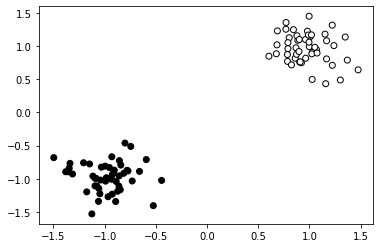

In [ ]:
X=(X - X.mean(dim=0)) / X.std(dim=0)
print(X.mean(dim=0), X.std(dim=0), sep='\n')
plt.scatter(X[:, 0], X[:, 1],
            c=Y, cmap="Greys", edgecolor="black");

In [ ]:
b=5
range0, range1 = torch.linspace(-7, 7, 100), torch.linspace(-7, 7, 100)
grid0, grid1   = torch.meshgrid(range0, range1)
grid_cost      = torch.zeros(grid0.size())
for index0 in range(len(range0)):
  for index1 in range(len(range1)):
    w0 = grid0[index0,index1]
    w1 = grid1[index0,index1]
    grid_cost[index0,index1] = C(H(model(w0, w1, b, X[:, 0], X[:, 1]), Y))

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


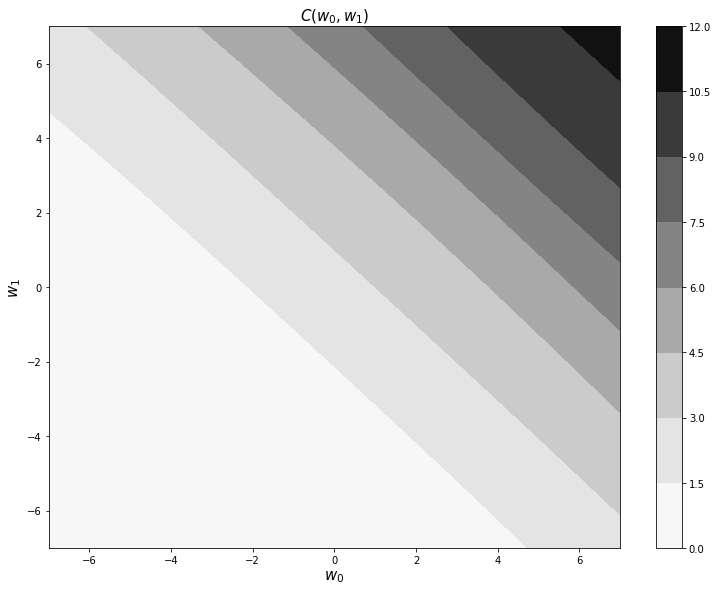

In [ ]:
plt.figure(figsize=[12.8, 9.6])
plt.contourf(grid0, grid1, grid_cost, cmap="Greys");
plt.xlabel("$w_0$", size=15)
plt.ylabel("$w_1$", size=15)
plt.title("$C(w_0,w_1)$", size=15)
plt.colorbar();

#Batch Norm

In [ ]:
from torch import nn
from torch import Tensor
from torch.nn import functional as F
class BN(nn.Module):
  def __init__(self, in_features):
      super().__init__()
      self.gamma      = nn.Parameter(torch.ones(in_features))
      self.beta       = nn.Parameter(torch.zeros(in_features))
      self.mu_avg     = torch.tensor(0)
      self.sigma2_avg = torch.tensor(1)
  def forward(self, input):
    if self.training:
      mu     = input.mean(dim=0)
      sigma2 = input.var(dim=0)
      with torch.no_grad():
        self.mu_avg     = 0.9*self.mu_avg + 0.1*mu
        self.sigma2_avg = 0.9*self.sigma2_avg + 0.1*sigma2
    else:
      mu     = self.mu_avg
      sigma2 = self.sigma2_avg
    xhat = (input - mu) / torch.sqrt((sigma2) + 10**-5)
    y=self.gamma * xhat + self.beta
    return y

#Layer mean and STD calculation

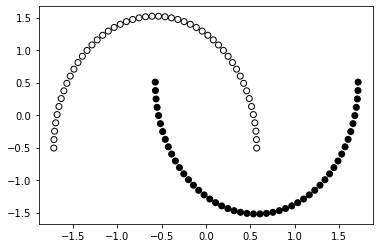

In [ ]:
X, Y = skds.make_moons(n_samples=100, random_state=1)
#X, Y = skds.make_blobs(n_samples=100,n_features=2,centers=2,random_state=1)
X = torch.tensor(X).float()
Y = torch.tensor(Y).float()
X = (X - X.mean(dim=0)) / X.std(dim=0)
plt.scatter(X[:, 0], X[:, 1],
              c=Y, cmap="Greys", edgecolor="black");

In [ ]:
def clip_prob(y, eps):
  eps = torch.tensor(eps)
  return torch.max(eps, torch.min(1-eps,y)) 

def draw_prob_contours():
  x0, x1       = torch.linspace(-2, 2, 100), torch.linspace(-2, 2, 100)
  grid0, grid1 = torch.meshgrid(x0, x1)
  model_input  = torch.cartesian_prod(x0, x1)
  model_output = model(model_input).reshape(100,100).detach()
  plt.scatter(X[:, 0], X[:, 1],
            c=Y, cmap="Greys", edgecolor="black");
  fig = plt.contour(grid0, grid1, model_output, cmap="Greys");
  fig.clabel(inline=True, fontsize=10);

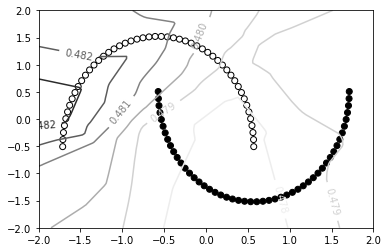

In [ ]:
class LinearRelu(nn.Linear):
  def forward(self, input):
    return F.relu(super(LinearRelu,self).forward(input))
model = nn.Sequential(LinearRelu(2,10),
                      LinearRelu(10,10),
                      LinearRelu(10,10),
                      LinearRelu(10,10),
                      LinearRelu(10,10),
                      nn.Linear(10,1),
                      nn.Sigmoid(),
                      )
optimizer = torch.optim.SGD(model.parameters(), lr=1)
draw_prob_contours()

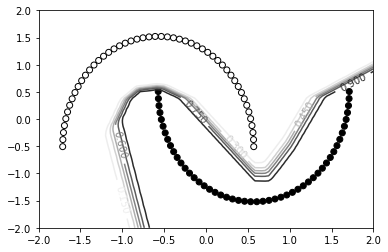

In [ ]:
for _ in range(100):
  optimizer.zero_grad()
  y_model = torch.squeeze(model(X))
  y_model_clipped = clip_prob(y_model, 10**-4)
  CE_loss = -1/len(Y) * torch.sum(Y*torch.log(y_model_clipped) + (1-Y)*torch.log(1-y_model_clipped))
  CE_loss.backward()
  optimizer.step()  
draw_prob_contours()

In [ ]:
input = X
layermean = []
layerstd  = []
layermean.append(input.mean(dim=0).detach().numpy())
layerstd.append(input.std(dim=0).detach().numpy())
for idx in range(len(model)):
  layer = model[idx]
  input = layer(input)
  layermean.append(input.mean(dim=0).detach().numpy())
  layerstd.append(input.std(dim=0).detach().numpy())

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


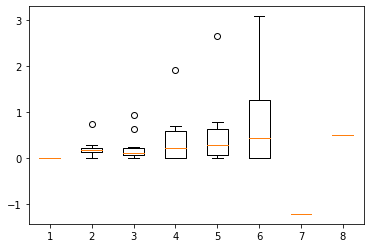

In [ ]:
plt.boxplot(layermean);

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


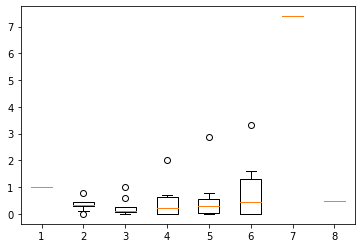

In [ ]:
plt.boxplot(layerstd);